# Model Training for Appliance Energy Prediction
## *XGBoost Quantile Regression with optimized hyperparameters*


###  Model Training Pipeline -Trains XGBoost quantile regression model for 2-hour ahead prediction with post-processing


## 1. Imports and Setup

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from src.config import data_paths, model_paths


## 2. Load Engineered Features


In [3]:
# Load the engineered dataset
print("Loading engineered features...")
df = pd.read_csv(data_paths.engineered_features)
print(f"Dataset shape: {df.shape}")


# Preview data
print(f"\nFirst few rows:")
df.head(10)

Loading engineered features...
Dataset shape: (19733, 57)

First few rows:


,date,hour_sin,hour_cos,target_hour_sin,dow_sin,month_sin,day_of_week,target_dow,month,lag_1h,...,is_weekend,target_is_peak,is_local_peak,is_local_trough,spike_intensity_24h,evening_x_level,weekend_x_level,avg_this_hour,trend_6h,target
0,2016-01-11 17:00:00,-0.965926,-2.588190e-01,-0.965926,0.0,0.5,0,0,1,0.0,...,0,1,0,0,0.000000,60,0,0.0,0.000000,50.0
1,2016-01-11 17:10:00,-0.965926,-2.588190e-01,-0.965926,0.0,0.5,0,0,1,60.0,...,0,1,0,0,0.000000,60,0,0.0,0.000000,50.0
2,2016-01-11 17:20:00,-0.965926,-2.588190e-01,-0.965926,0.0,0.5,0,0,1,60.0,...,0,1,0,0,0.000000,50,0,0.0,0.000000,60.0
3,2016-01-11 17:30:00,-0.965926,-2.588190e-01,-0.965926,0.0,0.5,0,0,1,50.0,...,0,1,0,0,0.000000,50,0,0.0,0.000000,50.0
4,2016-01-11 17:40:00,-0.965926,-2.588190e-01,-0.965926,0.0,0.5,0,0,1,50.0,...,0,1,1,0,0.000000,60,0,0.0,0.000000,60.0
5,2016-01-11 17:50:00,-0.965926,-2.588190e-01,-0.965926,0.0,0.5,0,0,1,60.0,...,0,1,0,1,0.000000,50,0,0.0,0.000000,60.0
6,2016-01-11 18:00:00,-1.000000,-1.836970e-16,-0.866025,0.0,0.5,0,0,1,50.0,...,0,1,0,0,0.000000,60,0,0.0,-1.428571,60.0
7,2016-01-11 18:10:00,-1.000000,-1.836970e-16,-0.866025,0.0,0.5,0,0,1,60.0,...,0,1,0,0,0.000000,60,0,0.0,0.285714,70.0
8,2016-01-11 18:20:00,-1.000000,-1.836970e-16,-0.866025,0.0,0.5,0,0,1,60.0,...,0,1,0,0,1.048035,60,0,0.0,2.000000,230.0
9,2016-01-11 18:30:00,-1.000000,-1.836970e-16,-0.866025,0.0,0.5,0,0,1,60.0,...,0,1,0,0,1.213873,70,0,0.0,1.714286,580.0


## 3. Train-Validation-Test Split
###### Temporal split: 70% train, 15% validation, 15% test (no shuffling to preserve time order)


In [4]:
def temporal_split(df, train_ratio=0.7, val_ratio=0.15):
    """
    Splits data temporally to prevent data leakage
    Returns train, validation, and test sets
    """
    # Remove rows with missing target
    df_clean = df.dropna(subset=['target']).reset_index(drop=True)
    
    n = len(df_clean)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    train = df_clean.iloc[:train_end]
    val = df_clean.iloc[train_end:val_end]
    test = df_clean.iloc[val_end:]
    
    return train, val, test

# %%
# Perform split
train, val, test = temporal_split(df)

print("Dataset Split:")
print(f"  Train:      {len(train):,} samples ({len(train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(val):,} samples ({len(val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(test):,} samples ({len(test)/len(df)*100:.1f}%)")


Dataset Split:
  Train:      13,813 samples (70.0%)
  Validation: 2,960 samples (15.0%)
  Test:       2,960 samples (15.0%)


## 4. Prepare Feature Matrices
###### Extract X (features) and y (target) with missing value imputation


In [5]:
# Load feature names
from src.config import feature_config
features = feature_config.get_all_features()

print(f"Number of features: {len(features)}")

Number of features: 55


In [6]:
# Prepare train set
X_train = train[features].fillna(0)
y_train = train['target']

# Prepare validation set
X_val = val[features].fillna(0)
y_val = val['target']

# Prepare test set
X_test = test[features].fillna(0)
y_test = test['target']

print("\nFeature Matrix Shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")


Feature Matrix Shapes:
  X_train: (13813, 55)
  X_val:   (2960, 55)
  X_test:  (2960, 55)


## 5. Create DMatrix Objects
###### XGBoost-optimized data structure for faster training


In [7]:
# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

print("DMatrix objects created successfully")

DMatrix objects created successfully


## 6. Define Model Hyperparameters
###### Optimized parameters from ablation testing for quantile regression


In [8]:
# XGBoost parameters for median (Q50) quantile regression
params = {
    # Tree structure
    'max_depth': 6,                    # Maximum tree depth (controls complexity)
    'min_child_weight': 3,             # Minimum sum of instance weight in child
    'gamma': 0.2,                      # Minimum loss reduction for split
    
    # Learning rate and regularization
    'eta': 0.01,                       # Learning rate (small for stability)
    'reg_alpha': 0.3,                  # L1 regularization term
    'reg_lambda': 2.5,                 # L2 regularization term
    
    # Sampling
    'subsample': 0.75,                 # Row sampling ratio per tree
    'colsample_bytree': 0.7,           # Column sampling ratio per tree
    'colsample_bylevel': 0.7,          # Column sampling ratio per tree level
    
    # Objective
    'objective': 'reg:quantileerror',  # Quantile regression loss
    'quantile_alpha': 0.5,             # Target quantile (0.5 = median)
    
    # Training
    'tree_method': 'hist',             # Histogram-based algorithm (fast)
    'seed': 42                         # Random seed for reproducibility
}

print("Hyperparameters:")
for key, value in params.items():
    print(f"  {key:20s}: {value}")


Hyperparameters:
  max_depth           : 6
  min_child_weight    : 3
  gamma               : 0.2
  eta                 : 0.01
  reg_alpha           : 0.3
  reg_lambda          : 2.5
  subsample           : 0.75
  colsample_bytree    : 0.7
  colsample_bylevel   : 0.7
  objective           : reg:quantileerror
  quantile_alpha      : 0.5
  tree_method         : hist
  seed                : 42


## 7. Train XGBoost Model
###### Training with early stopping on validation set to prevent overfitting


In [9]:
print("\n" + "="*80)
print("TRAINING XGBOOST MODEL")
print("="*80)

# Training configuration
num_boost_round = 3000         # Maximum number of boosting rounds
early_stopping_rounds = 150    # Stop if no improvement for 150 rounds

# Train model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=100  # Print every 100 rounds
)

print(f"\n✓ Training complete")
print(f"Best iteration: {model.best_iteration}")
print(f"Best validation score: {model.best_score:.4f}")


TRAINING XGBOOST MODEL


[0]	train-quantile:26.32251	val-quantile:21.21452
[100]	train-quantile:20.14858	val-quantile:16.32366
[200]	train-quantile:17.61361	val-quantile:14.96038
[300]	train-quantile:16.29981	val-quantile:14.41918
[400]	train-quantile:15.59944	val-quantile:14.22624
[500]	train-quantile:15.13580	val-quantile:14.11671
[600]	train-quantile:14.78012	val-quantile:14.09354
[700]	train-quantile:14.47623	val-quantile:14.09789
[745]	train-quantile:14.33812	val-quantile:14.09869

✓ Training complete
Best iteration: 595
Best validation score: 14.0903


## 8. Generate Raw Predictions
###### Initial predictions before post-processing

In [10]:
# Make predictions on all sets
pred_train = model.predict(dtrain)
pred_val = model.predict(dval)
pred_test = model.predict(dtest)

print("\nRaw Predictions Generated:")
print(f"  Train: {len(pred_train):,} predictions")
print(f"  Val:   {len(pred_val):,} predictions")
print(f"  Test:  {len(pred_test):,} predictions")



Raw Predictions Generated:
  Train: 13,813 predictions
  Val:   2,960 predictions
  Test:  2,960 predictions


## 9. Post-Processing: Smoothing Function
###### Adaptive smoothing to reduce unrealistic jumps between consecutive predictions


In [11]:
def smooth_predictions(predictions, prev_values):
    """
    Applies adaptive smoothing based on previous value magnitude
    Reduces large jumps that are physically unrealistic
    
    Args:
        predictions: Raw model predictions
        prev_values: Previous actual or predicted values
    
    Returns:
        Smoothed predictions
    """
    smoothed = predictions.copy()
    
    for i in range(1, len(smoothed)):
        prev_val = prev_values[i-1] if i == 1 else smoothed[i-1]
        curr_val = smoothed[i]
        jump = abs(curr_val - prev_val)
        
        # Adaptive smoothing based on magnitude
        if prev_val < 150:
            # Low usage state - aggressive smoothing
            if jump > 200:
                smoothed[i] = 0.4 * curr_val + 0.6 * prev_val
            elif jump > 120:
                smoothed[i] = 0.6 * curr_val + 0.4 * prev_val
                
        elif prev_val < 300:
            # Medium usage state - moderate smoothing
            if jump > 300:
                smoothed[i] = 0.45 * curr_val + 0.55 * prev_val
            elif jump > 180:
                smoothed[i] = 0.65 * curr_val + 0.35 * prev_val
                
        else:
            # High usage state - light smoothing
            if jump > 400:
                smoothed[i] = 0.5 * curr_val + 0.5 * prev_val
            elif jump > 250:
                smoothed[i] = 0.7 * curr_val + 0.3 * prev_val
    
    # Ensure non-negative predictions
    smoothed = np.maximum(smoothed, 0)
    
    return smoothed

## 10. Apply Post-Processing
###### Smooth test predictions using actual previous values

In [12]:
print("\nApplying post-processing...")

# Use actual previous values for initial smoothing context
y_test_arr = y_test.values
pred_test_smoothed = smooth_predictions(pred_test, y_test_arr)

print("✓ Smoothing applied")


Applying post-processing...
✓ Smoothing applied


## 11. Calculate Basic Metrics
##### Quick performance check (detailed evaluation in separate notebook)


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate metrics
mae_raw = mean_absolute_error(y_test, pred_test)
mae_smoothed = mean_absolute_error(y_test, pred_test_smoothed)
rmse_raw = np.sqrt(mean_squared_error(y_test, pred_test))
rmse_smoothed = np.sqrt(mean_squared_error(y_test, pred_test_smoothed))

# Select best predictions
use_smoothed = mae_smoothed < mae_raw
final_pred = pred_test_smoothed if use_smoothed else pred_test
final_mae = min(mae_smoothed, mae_raw)

print("\n" + "="*80)
print("QUICK PERFORMANCE CHECK")
print("="*80)
print(f"Raw MAE:          {mae_raw:.2f}")
print(f"Smoothed MAE:     {mae_smoothed:.2f}")
print(f"Final MAE:        {final_mae:.2f}")
print(f"Raw RMSE:         {rmse_raw:.2f}")
print(f"Smoothed RMSE:    {rmse_smoothed:.2f}")
print(f"\nUsing: {'Smoothed' if use_smoothed else 'Raw'} predictions")


QUICK PERFORMANCE CHECK
Raw MAE:          26.86
Smoothed MAE:     27.00
Final MAE:        26.86
Raw RMSE:         72.23
Smoothed RMSE:    72.63

Using: Raw predictions


## 12. Feature Importance Analysis
###### Identify most influential features using gain metric


In [14]:
# Get feature importance
importance = model.get_score(importance_type='gain')
importance_df = pd.DataFrame([
    {'feature': k, 'importance': v} 
    for k, v in importance.items()
]).sort_values('importance', ascending=False)

print("\n" + "="*80)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*80)
print(f"\n{'Rank':<6} {'Feature':<30} {'Importance'}")
print("-" * 60)

for i, row in enumerate(importance_df.head(20).itertuples(), 1):
    print(f"{i:<6} {row.feature:<30} {row.importance:>12.1f}")


TOP 20 MOST IMPORTANT FEATURES

Rank   Feature                        Importance
------------------------------------------------------------
1      ema_3h                                 31.7
2      lag_1h                                 26.0
3      ema_6h                                 15.4
4      usage_regime                           14.9
5      roll_6h_mean                           10.9
6      roll_3h_mean                            9.9
7      is_night                                7.7
8      roll_12h_max                            6.0
9      roll_6h_max                             4.8
10     roll_12h_mean                           4.7
11     target_hour_sin                         4.7
12     dist_from_24h_min                       4.5
13     evening_x_level                         4.5
14     zscore_168h                             4.0
15     dist_from_6h_min                        3.8
16     is_local_peak                           3.8
17     is_local_trough                   

## 13. Save Trained Model
###### Persist model and predictions for evaluation and deployment


In [15]:
model_paths.models_dir.mkdir(parents=True, exist_ok=True)
model_paths.predictions_dir.mkdir(parents=True, exist_ok=True)


# Save XGBoost model
model.save_model(model_paths.xgboost_model)
model_path = model_paths.xgboost_model

print(f"\n✓ Model saved to: {model_path}")

# Save model as pickle (alternative format)
pickle_path = model_paths.xgboost_pickle
with open(pickle_path, 'wb') as f:
    pickle.dump(model, f)

print(f"✓ Model saved to: {pickle_path}")


✓ Model saved to: C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\xgboost_model.json
✓ Model saved to: C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\xgboost_model.pkl


## 14. Save Predictions
###### Store predictions for evaluation notebook

In [16]:
predictions_df = pd.DataFrame({
    'date': test['date'].values,
    'actual': y_test.values,
    'predicted_raw': pred_test,
    'predicted_smoothed': pred_test_smoothed,
    'final_prediction': final_pred
})

pred_path = model_paths.test_predictions
predictions_df.to_csv(pred_path, index=False)

print(f"✓ Predictions saved to: {pred_path}")

✓ Predictions saved to: C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\predictions\test_predictions.csv


## 15. Save Feature Importance
###### Export importance scores for analysis

In [17]:
importance_path = model_paths.feature_importance
importance_df.to_csv(importance_path, index=False)

print(f"✓ Feature importance saved to: {importance_path}")

✓ Feature importance saved to: C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\feature_importance.csv


In [18]:
## 16. Save Training Metadata
# Document training configuration and results

# %%
metadata = {
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'XGBoost Quantile Regression',
    'n_features': len(features),
    'n_train_samples': len(train),
    'n_val_samples': len(val),
    'n_test_samples': len(test),
    'best_iteration': int(model.best_iteration),
    'best_validation_score': float(model.best_score),
    'test_mae_raw': float(mae_raw),
    'test_mae_smoothed': float(mae_smoothed),
    'test_mae_final': float(final_mae),
    'test_rmse_final': float(rmse_smoothed if use_smoothed else rmse_raw),
    'used_smoothing': bool(use_smoothed),
    'hyperparameters': params
}

metadata_path = model_paths.training_metadata
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Metadata saved to: {metadata_path}")

# %% [markdown]
## 17. Save Split Indices
# Store data split information for reproducibility

# %%
split_info = {
    'train_indices': train.index.tolist(),
    'val_indices': val.index.tolist(),
    'test_indices': test.index.tolist(),
    'train_date_range': [str(train['date'].min()), str(train['date'].max())],
    'val_date_range': [str(val['date'].min()), str(val['date'].max())],
    'test_date_range': [str(test['date'].min()), str(test['date'].max())]
}

split_path = model_paths.split_info
with open(split_path, 'w') as f:
    json.dump(split_info, f, indent=2)

print(f"✓ Split info saved to: {split_path}")

# %% [markdown]
## 18. Training Summary Report

# %%
print("\n" + "="*80)
print("TRAINING COMPLETE - SUMMARY")
print("="*80)
print(f"\nModel Configuration:")
print(f"  Algorithm:        XGBoost Quantile Regression")
print(f"  Features:         {len(features)}")
print(f"  Training samples: {len(train):,}")
print(f"  Best iteration:   {model.best_iteration}")

print(f"\nPerformance:")
print(f"  Test MAE:         {final_mae:.2f} Wh")
print(f"  Test RMSE:        {(rmse_smoothed if use_smoothed else rmse_raw):.2f} Wh")
print(f"  Smoothing used:   {'Yes' if use_smoothed else 'No'}")

print(f"\nFiles Saved:")
print(f"  1. {model_path}")
print(f"  2. {pickle_path}")
print(f"  3. {pred_path}")
print(f"  4. {importance_path}")
print(f"  5. {metadata_path}")
print(f"  6. {split_path}")

print("\n✓ Model ready for evaluation and deployment!")
print("=" * 80)


✓ Metadata saved to: C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\training_metadata.json
✓ Split info saved to: C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\split_info.json

TRAINING COMPLETE - SUMMARY

Model Configuration:
  Algorithm:        XGBoost Quantile Regression
  Features:         55
  Training samples: 13,813
  Best iteration:   595

Performance:
  Test MAE:         26.86 Wh
  Test RMSE:        72.23 Wh
  Smoothing used:   No

Files Saved:
  1. C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\xgboost_model.json
  2. C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\xgboost_model.pkl
  3. C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\predictions\test_predictions.csv
  4. C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\feature_importance.csv
  5. C:\Users\lekshmi\Desktop\

## 19. Quick Visualization
###### Simple prediction vs actual plot for sanity check

✓ Visualization saved to: C:\Users\lekshmi\Desktop\Energy_Forecasting\Energy-Consumption-Forecasting\models\predictions\quick_check_plot.png


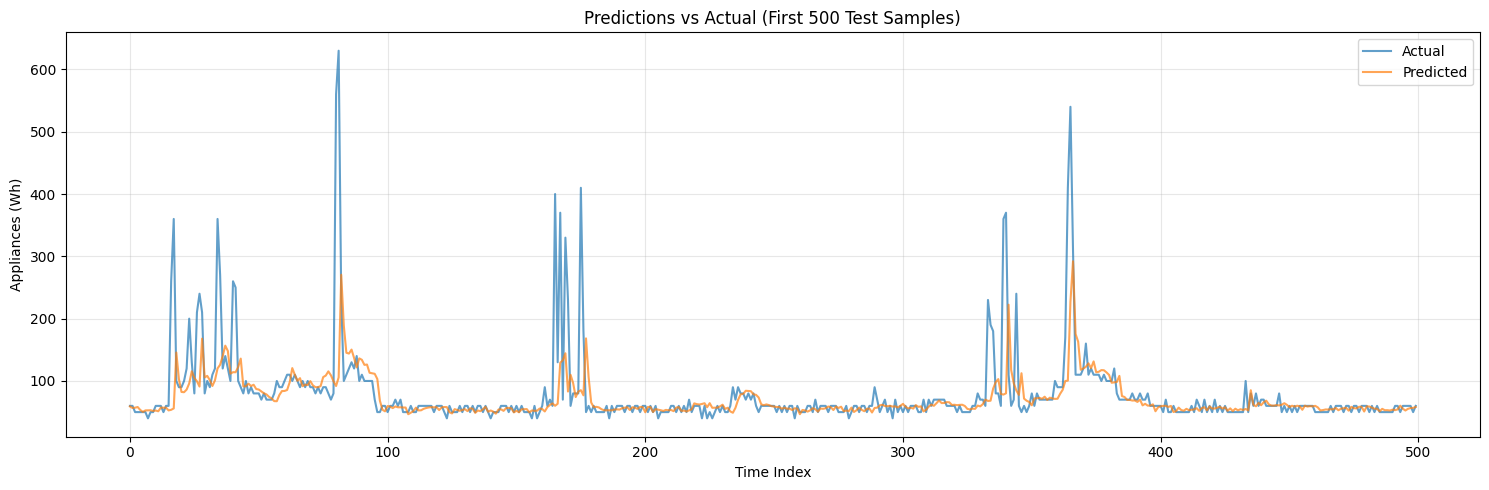

In [19]:
import matplotlib.pyplot as plt

# Plot first 500 test predictions
n_plot = min(500, len(y_test))
plt.figure(figsize=(15, 5))
plt.plot(range(n_plot), y_test.values[:n_plot], label='Actual', alpha=0.7, linewidth=1.5)
plt.plot(range(n_plot), final_pred[:n_plot], label='Predicted', alpha=0.7, linewidth=1.5)
plt.xlabel('Time Index')
plt.ylabel('Appliances (Wh)')
plt.title('Predictions vs Actual (First 500 Test Samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
plot_path = model_paths.quick_check_plot
plt.savefig(plot_path, dpi=100, bbox_inches='tight')
print(f"✓ Visualization saved to: {plot_path}")
plt.show()
